In [1]:
# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
import warnings
warnings.filterwarnings(action = "ignore")

# 데이터 처리 모듈
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# 멀티프로세싱
import multiprocessing as mp
from multiprocessing import Pool

# 척도 변환 모듈(표준화, 정규화, 로버스트 정규화, 원핫인코딩(범주형에서 더미변수로 변환) 등)
from sklearn.preprocessing import *

# 결측값 관측 모듈
import missingno as msno

# 시각화 모듈
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# 배열, 행렬 연산 모듈
import numpy as np

# 데이터 분할 모듈(훈련용 / 검증용 / 시험용)
from sklearn.model_selection import train_test_split

# 통계적 가설검정 및 계량화 모듈
# https://youtu.be/FtWEZw3kUho
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.interpolate import UnivariateSpline

# 타입 어노테이션 모듈
from typing import *

# 시간 관련 모듈
from tqdm import tqdm
from time import strptime, sleep

# 웹크롤링 / 스크래핑 관련 모듈
import requests
import io
import zipfile
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

# 결측값 대체 및 특징 추출
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, SparsePCA

# 연관규칙 분석 실행 모듈
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# 한글폰트 설정
import matplotlib.font_manager as fm
font = fm.FontProperties(fname = "./NotSansKR-Regular.otf")

Mounted at /content/drive


In [2]:
class AprioriRuleswithEvent():

  def __init__(self, file_path: str, DROP_COLUMN_LIST: List, SUBSET = None):

    self.INDEX_NEWS_DATA = pd.read_csv(file_path, index_col = False, na_values = "NaN")
      # [file_path] "/content/drive/MyDrive/AfterLearnerProject/DataArchive/merge_derivative_news_data.csv"
      # [INDEX_PRINCIPAL_COMPONENT_x] 시계열 전처리한 5개 주가지수선형결합 제1주성분
      # [INDEX_PRINCIPAL_COMPONENT_y] 시계열 전처리한 5개 주가지수선형결합 제1주성분의 단위변동률
    self.INDEX_NEWS_DROPNA = self.INDEX_NEWS_DATA.dropna(subset = DROP_COLUMN_LIST)
      # msno.dendrogram()
    self.SUBSET = SUBSET


  def compareEventDatetimewithNewsImportanceScore(self):
    # improtance와 특이 지점을 비교하기 위해 importance값 상위 20개 추출(특이지점과 흡사)
    display( self.INDEX_NEWS_DATA.sort_values(
        by = "IMPORTANCE", ascending = False).head(20)[["IMPORTANCE", "YYYYMMDD", "TAG_LIST"]] )


  def removeBlank(self):
    import re
    self.INDEX_NEWS_DROPNA["TAG_LIST"] = self.INDEX_NEWS_DROPNA["TAG_LIST"].apply(
        lambda tag: re.sub(" ", "", tag))
    self.INDEX_NEWS_DROPNA["ITEM_NAME"] = self.INDEX_NEWS_DROPNA["ITEM_NAME"].apply(lambda tag: re.sub(" ", "", tag))
      # "\s{0,}"
      # re.sub(" +", "" , string)
      # " ".join(string.split())


  def mutateNewColumn(self):
    self.INDEX_NEWS_DROPNA["CHANGE_CATEGORY"] = (
        self.INDEX_NEWS_DROPNA["STABLE_or_DRAMATIC"].astype(str) + "_" + self.INDEX_NEWS_DROPNA["SIGN_CHANGE"].astype(str))
    self.INDEX_NEWS_DROPNA["TAG_SPLIT"] = self.INDEX_NEWS_DROPNA.TAG_LIST.str.split("|")
    self.INDEX_NEWS_DROPNA["ITEM_SPLIT"] = self.INDEX_NEWS_DROPNA.ITEM_NAME.str.split("|")
    print( "\n", Counter(self.INDEX_NEWS_DROPNA["CHANGE_CATEGORY"]) , "\n", Counter(self.INDEX_NEWS_DROPNA["YYYYMMDD"]) )


  def makeSubDataset_loadData(self, date_column: str, date_time: str):

    INDEX_NEWS_DATETIME = self.INDEX_NEWS_DROPNA[ self.INDEX_NEWS_DROPNA[date_column] == date_time ]
    self.SUBSET = INDEX_NEWS_DATETIME[["CHANGE_CATEGORY", "SUBCATEGORY"]].values
      # [column] "ITEM_NAME", "SUBCATEGORY"
    return self.SUBSET, INDEX_NEWS_DATETIME
      # [date_column] YYYYMMDD


  # Apriori Analysis
  def find_frequent_TAGsets(self, transaction_itemset: pd.Series, transaction_tagset: pd.Series,
                            drop_tagset_list: List,
                            minimum_support_threshold: float,
                            minimum_confidence_threshold: float):

      transaction_item_encoder = TransactionEncoder()
      transaction_tag_encoder = TransactionEncoder()
      transaction_item_array = transaction_item_encoder.fit_transform(transaction_itemset)
      transaction_tag_array = transaction_tag_encoder.fit_transform(transaction_tagset)

      transaction_itemset_dataframe = pd.DataFrame(
          data = transaction_item_array, columns = transaction_item_encoder.columns_)
      transaction_tagset_dataframe = pd.DataFrame(
          data = transaction_tag_array, columns = transaction_tag_encoder.columns_)
      transaction_dataframe = pd.concat(
          [transaction_itemset_dataframe, transaction_tagset_dataframe],
          axis = 1, ignore_index = False)

    # 이 지지도 이하의 규칙들은 배제하는 threshold (임계점 or 한계치)를 설정
      frequent_TAG_sets = apriori(
          transaction_dataframe,
          max_len = 2,
          min_support = minimum_support_threshold,
          use_colnames = True )

    # apriori에 최소 지지도를 적용한 빈발원소집합, frequent_TAG_sets에서
    # [metric][confidence] 품목 사이의 연관정 정도를 측정하기 위해 사용되는 지표
    # [metric][lift] 두 사건이 서로 독립일 때와 비교해 얼마나 발생했는가에 대해 비율
    # print(apriori.__doc__)
      apriori_rules = association_rules(
          frequent_TAG_sets, metric = "confidence", min_threshold = minimum_confidence_threshold)
      return apriori_rules


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
financialApriori = AprioriRuleswithEvent(
    file_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/merge_derivative_news_data.csv",
    DROP_COLUMN_LIST = ["TAG_LIST", "ITEM_NAME"]
)

financialApriori.compareEventDatetimewithNewsImportanceScore()
financialApriori.removeBlank()
financialApriori.mutateNewColumn()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,IMPORTANCE,YYYYMMDD,TAG_LIST
43463,168.84,2023-02-01,게임| 리니지| 결제| 아이템| 산업| 디아블로| 캐릭터| 장비| 그래픽| PC| ...
42206,146.29,2023-02-01,2차전지| 글로벌| 전기차| 전극| 자동차| 장비| 에너지| 배터리팩| 주행거리| 가전
4243,129.80,2023-01-25,코로나| 호텔| 중국| 면세점| 여행| 관광객| 화장품| 제주| 일본| 여권| 소비
60764,125.75,2023-02-02,우주| 공연| 축구| 스포츠| 경찰| 공기| 발사| 문화| 태풍| 조선| 겨울| 운동
19339,111.14,2023-01-26,가구| 전기| 가스
13673,107.20,2023-01-26,교육| 양육
14055,100.42,2023-01-26,일본| 캐릭터| 도깨비| 캔버스
7666,100.09,2023-01-25,기온| 추위| 바닷물| 난방| 겨울| 청주| 제주
5739,98.79,2023-01-25,제주| 공항| 기온
32676,96.63,2023-01-31,경찰| 테러



 Counter({'DRAMATIC_Not Change': 12281, 'DRAMATIC_Sign Change': 3252}) 
 Counter({'2023-03-15': 2918, '2023-03-10': 2152, '2023-04-12': 1858, '2023-02-01': 1687, '2023-01-31': 1621, '2023-02-02': 1565, '2023-01-26': 1376, '2023-01-25': 1294, '2023-01-27': 1062})


## **2023-01-25** | DRAMATIC_Not Change
(AI)	(인공지능) | (인공지능)	(AI)

(은행)	(금리) | (대출)	(금리)


In [4]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230125, merge_derivative_news_data_230125 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-01-25")
# pd.set_option("display.max_row", 10)
# Counter(merge_derivative_news_data_230125["SUBCATEGORY"])

apriori_results_230125: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230125["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230125["TAG_SPLIT"],
      drop_tagset_list = [""],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230125.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230125[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230125[1].sort_values("confidence", ascending = False) )
display( apriori_results_230125[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
222,(OLED),(디스플레이),0.006182,0.022411,0.006182,1.000000,44.620690,0.006044,inf,0.983670
43,(바이러스),(LG전자),0.005410,0.016229,0.005410,1.000000,61.619048,0.005322,inf,0.989122
199,(광산),(EV),0.005410,0.013138,0.005410,1.000000,76.117647,0.005339,inf,0.992230
71,(앱스토어),(넥슨게임즈),0.005410,0.008501,0.005410,1.000000,117.636364,0.005364,inf,0.996892
196,(채식주의),(CU),0.006182,0.009274,0.006182,1.000000,107.833333,0.006125,inf,0.996890
...,...,...,...,...,...,...,...,...,...,...
251,(아시아),(네트워크),0.017002,0.011592,0.006955,0.409091,35.290909,0.006758,1.672691,0.988470
311,(아시아),(헬스케어),0.017002,0.023184,0.006955,0.409091,17.645455,0.006561,1.653073,0.959644
102,(아시아),(메드팩토),0.017002,0.007728,0.006955,0.409091,52.936364,0.006824,1.679230,0.998078
228,(PC),(전기차),0.020866,0.044049,0.008501,0.407407,9.248863,0.007582,1.613167,0.910885


## **2023-01-26** | DRAMATIC_Not Change

(대출)	(금리) | (금리, 은행)	(대출)

(무인기)	(북한)	| (북한)	(무인기)

In [6]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230126, merge_derivative_news_data_230126 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-01-26")

apriori_results_230126: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230126["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230126["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230126.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230126[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230126[1].sort_values("confidence", ascending = False) )
display( apriori_results_230126[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CU),(BGF리테일),0.005087,0.005814,0.005087,1.000000,172.000000,0.005058,inf,0.999270
150,(고부가가치),(현대차),0.010174,0.067587,0.010174,1.000000,14.795699,0.009487,inf,0.941997
259,(구리),(필터),0.006541,0.014535,0.006541,1.000000,68.800000,0.006446,inf,0.991953
253,(구리),(에너지),0.006541,0.039971,0.006541,1.000000,25.018182,0.006279,inf,0.966350
74,(브릿지바이오테라퓨틱스),(치료제),0.005087,0.034884,0.005087,1.000000,28.666667,0.004910,inf,0.970051
...,...,...,...,...,...,...,...,...,...,...
175,(ESG),(결제),0.015988,0.022529,0.006541,0.409091,18.158358,0.006180,1.654182,0.960282
76,(삼성SDI),(현대차),0.014535,0.067587,0.005814,0.400000,5.918280,0.004832,1.554021,0.843289
75,(삼성SDI),(엘앤에프),0.014535,0.018895,0.005814,0.400000,21.169231,0.005539,1.635174,0.966814
285,(도시가스),(난방),0.014535,0.012355,0.005814,0.400000,32.376471,0.005634,1.646076,0.983407


## **2023-01-27** | DRAMATIC_Not Change
(마스크)	(코로나19) | (코로나19) (마스크)

(전기차)	(중국)	| (전기차)	(글로벌)

(전기차)  (배터리)	| (배터리)	(전기차)

In [8]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230127, merge_derivative_news_data_230127 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-01-27")

apriori_results_230127: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230127["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230127["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230127.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230127[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230127[1].sort_values("confidence", ascending = False) )
display( apriori_results_230127[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
187,(상사),(LNG),0.005650,0.013183,0.005650,1.0,75.857143,0.005575,inf,0.992424
197,(사운드),(OLED),0.005650,0.036723,0.005650,1.0,27.230769,0.005442,inf,0.968750
165,(B2B),(글로벌),0.005650,0.195857,0.005650,1.0,5.105769,0.004543,inf,0.808712
164,(B2B),(TV),0.005650,0.083804,0.005650,1.0,11.932584,0.005176,inf,0.921402
163,(챗봇),(AI),0.010358,0.051789,0.010358,1.0,19.309091,0.009821,inf,0.958135
...,...,...,...,...,...,...,...,...,...,...
239,(공급망),(콘텐츠),0.014124,0.039548,0.005650,0.4,10.114286,0.005091,1.600753,0.914040
238,(공급망),(주력),0.014124,0.020716,0.005650,0.4,19.309091,0.005357,1.632141,0.961796
236,(공급망),(물류),0.014124,0.022599,0.005650,0.4,17.700000,0.005331,1.629002,0.957020
227,(공급망),(가전),0.014124,0.018832,0.005650,0.4,21.240000,0.005384,1.635279,0.966571


## **2023-01-31** | DRAMATIC_Not Change
(반도체)	(메모리) | (메모리)	(반도체) | (파운드리)	(반도체)

(반도체)	(글로벌) | (일본)	(중국) | (코로나19)	(중국) | (소비)	(중국)

(부동산)	(주택)	| (주택)	(부동산)

In [10]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230131, merge_derivative_news_data_230131 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-01-31")

apriori_results_230131: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230131["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230131["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230131.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230131[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230131[1].sort_values("confidence", ascending = False) )
display( apriori_results_230131[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
309,(에어컨),(친환경),0.005552,0.036397,0.005552,1.000000,27.474576,0.005350,inf,0.968983
300,(알루미늄),(양극재),0.005552,0.033313,0.005552,1.000000,30.018519,0.005367,inf,0.972084
246,(마이크로바이옴),(연구소),0.006786,0.007403,0.006786,1.000000,135.083333,0.006736,inf,0.999379
307,(에어컨),(인도),0.005552,0.009870,0.005552,1.000000,101.312500,0.005497,inf,0.995658
99,(종근당),(치료),0.006786,0.009254,0.006786,1.000000,108.066667,0.006723,inf,0.997516
...,...,...,...,...,...,...,...,...,...,...
129,(현대차),(자동차),0.028994,0.044417,0.011721,0.404255,9.101359,0.010433,1.604014,0.916706
180,(게임),(플랫폼),0.015423,0.054904,0.006169,0.400000,7.285393,0.005322,1.575159,0.876253
139,(5G),(스마트폰),0.015423,0.037014,0.006169,0.400000,10.806667,0.005598,1.604976,0.921679
292,(주력),(스마트폰),0.015423,0.037014,0.006169,0.400000,10.806667,0.005598,1.604976,0.921679


## **2023-02-01** | DRAMATIC_Sign Change

(중국)	(글로벌) | (리오프닝)	(중국)

(대출)	(금리)

(반도체)	(메모리)

In [12]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230201, merge_derivative_news_data_230201 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-02-01")

apriori_results_230201: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230201["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230201["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230201.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230201[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230201[1].sort_values("confidence", ascending = False) )
display( apriori_results_230201[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
58,(여객),(대한항공),0.008299,0.009484,0.008299,1.000000,105.437500,0.008220,inf,0.998805
11,(희토류),(KT),0.005335,0.017783,0.005335,1.000000,56.233333,0.005240,inf,0.987485
197,(소셜),(스타트업),0.005335,0.010670,0.005335,1.000000,93.722222,0.005278,inf,0.994636
35,(소셜),(SK텔레콤),0.005335,0.008299,0.005335,1.000000,120.500000,0.005291,inf,0.997020
84,(항원),(셀트리온),0.006520,0.027860,0.006520,1.000000,35.893617,0.006339,inf,0.978520
...,...,...,...,...,...,...,...,...,...,...
74,(스마트폰),(삼성전자),0.016005,0.098992,0.006520,0.407407,4.115547,0.004936,1.520451,0.769332
235,(치료),(환자),0.016005,0.026082,0.006520,0.407407,15.620370,0.006103,1.643487,0.951205
116,(2차전지),(신규상장),0.016005,0.014819,0.006520,0.407407,27.491852,0.006283,1.662493,0.979299
14,(화장품),(LG생활건강),0.014819,0.020747,0.005928,0.400000,19.280000,0.005620,1.632089,0.962395


## **2023-02-02** | DRAMATIC_Sign Change

(스마트폰)	(갤럭시) | (갤럭시)	(스마트폰) | (카메라)	(갤럭시) | (디지털)	(플랫폼)

(금리)	(중앙은행) | (금융)  (금리) | (채권)	(금리)

(배터리)	(전기차)	|  (전기차)	(배터리)



(전기)	(가스)

In [14]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230202, merge_derivative_news_data_230202 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-02-02")

apriori_results_230202: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230202["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230202["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230202.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230202[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230202[1].sort_values("confidence", ascending = False) )
display( apriori_results_230202[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
66,(여객),(대한항공),0.007668,0.019808,0.007668,1.000000,50.483871,0.007516,inf,0.987766
217,(세탁기),(냉장고),0.005112,0.007029,0.005112,1.000000,142.272727,0.005076,inf,0.998073
144,(친환경차),(현대차),0.006390,0.032588,0.006390,1.000000,30.686275,0.006182,inf,0.973633
84,(스냅드래곤),(삼성전자),0.005751,0.143770,0.005751,1.000000,6.955556,0.004924,inf,0.861183
88,(칩셋),(삼성전자),0.005112,0.143770,0.005112,1.000000,6.955556,0.004377,inf,0.860629
...,...,...,...,...,...,...,...,...,...,...
45,(NAVER),(금리),0.026837,0.040895,0.010863,0.404762,9.897693,0.009765,1.611297,0.923757
72,(카카오),(삼성전자),0.036422,0.143770,0.014696,0.403509,2.806628,0.009460,1.435444,0.668031
143,(전기차),(현대차),0.035144,0.032588,0.014058,0.400000,12.274510,0.012912,1.612354,0.951987
145,(신규상장),(2차전지),0.012780,0.016613,0.005112,0.400000,24.076923,0.004900,1.638978,0.970874


## **2023-03-10** | DRAMATIC_Not Change

(이머징마켓, 아시아)	(미국) | (미국, 이머징마켓)	(아시아) | (중국, 아시아)	(이머징마켓)

(EU, 미국) | (, 소재)	(미국)

(채권)	(금리)

In [16]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230310, merge_derivative_news_data_230310 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-03-10")

apriori_results_230310: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
      transaction_itemset = merge_derivative_news_data_230310["ITEM_SPLIT"],
      transaction_tagset = merge_derivative_news_data_230310["TAG_SPLIT"],
      drop_tagset_list = ["톰슨로이터"],
      minimum_support_threshold = threshold,
      minimum_confidence_threshold = confidence
    )
    apriori_results_230310.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230310[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230310[1].sort_values("confidence", ascending = False) )
display( apriori_results_230310[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
36,(),(톰슨로이터),0.111059,0.294610,0.294610,2.652720,9.004184,0.261890,inf,1.000000
93,(독일),(EU),0.006041,0.024628,0.006041,1.000000,40.603774,0.005892,inf,0.981300
37,(톰슨로이터),(),0.294610,0.111059,0.294610,1.000000,9.004184,0.261890,inf,1.260211
39,(프랑스),(),0.006041,0.111059,0.006041,1.000000,9.004184,0.005370,inf,0.894343
42,(호주),(),0.006041,0.111059,0.006041,1.000000,9.004184,0.005370,inf,0.894343
...,...,...,...,...,...,...,...,...,...,...
86,(제이피모간체이스),(미국),0.012546,0.148234,0.005112,0.407407,2.748404,0.003252,1.437355,0.644235
44,(LG전자),(대여),0.012546,0.009294,0.005112,0.407407,43.837037,0.004995,1.671817,0.989604
166,(콘텐츠),(플랫폼),0.012546,0.029275,0.005112,0.407407,13.916520,0.004744,1.638098,0.939936
28,(이머징마켓),(),0.032063,0.111059,0.013011,0.405797,3.653872,0.009450,1.496022,0.750377


## **2023-04-12** | DRAMATIC_Not Change
(미국, 아시아)	(이머징마켓) | (미국, 이머징마켓)	(아시아) | (아시아, 이머징마켓)	(미국)
(소재)	(미국) | (헬스케어)	(미국)	| (미세먼지)	(황사)
(중국, 이머징마켓)	(아시아) | (EU, 아시아)	(이머징마켓)

In [18]:
# date_time 변수가 9번 바뀌기 때문에 클래스로 선언하여 반복작업의 일부 자동화
merge_derivative_news_data_subset_230412, merge_derivative_news_data_230412 = financialApriori.makeSubDataset_loadData(
    date_column = "YYYYMMDD", date_time = "2023-04-12")

apriori_results_230412: List = []

for threshold in [0.005]:
  for confidence in [0.6, 0.5, 0.4]:
    apriori_rules = financialApriori.find_frequent_TAGsets(
        transaction_itemset = merge_derivative_news_data_230412["ITEM_SPLIT"],
        transaction_tagset = merge_derivative_news_data_230412["TAG_SPLIT"],
        drop_tagset_list = ["톰슨로이터"],
        minimum_support_threshold = threshold,
        minimum_confidence_threshold = confidence
    )
    apriori_results_230412.append(apriori_rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pd.set_option("display.max_row", 10)
# display( apriori_results_230412[0].sort_values("confidence", ascending = False) )
# display( apriori_results_230412[1].sort_values("confidence", ascending = False) )
display( apriori_results_230412[2].sort_values("confidence", ascending = False) )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(마이크로소프트),(),0.008073,0.097955,0.008073,1.000000,10.208791,0.007282,inf,0.909387
158,(필수소비재),(미국),0.006459,0.138859,0.006459,1.000000,7.201550,0.005562,inf,0.866739
2,(알파벳A),(),0.005382,0.097955,0.005382,1.000000,10.208791,0.004855,inf,0.906926
3,(웰스파고),(),0.005920,0.097955,0.005920,1.000000,10.208791,0.005340,inf,0.907417
107,(리조트),(TV),0.006997,0.022605,0.006997,1.000000,44.238095,0.006839,inf,0.984282
...,...,...,...,...,...,...,...,...,...,...
161,(미디어),(콘텐츠),0.023681,0.019376,0.009688,0.409091,21.113636,0.009229,1.659518,0.975744
25,(LG전자),(커뮤니케이션),0.017223,0.013455,0.006997,0.406250,30.192500,0.006765,1.661549,0.983823
91,(EU),(금융),0.019914,0.053821,0.008073,0.405405,7.532432,0.007001,1.591301,0.884862
129,(이머징마켓),(금융),0.024220,0.053821,0.009688,0.400000,7.432000,0.008384,1.576964,0.886928


```
support = association_rules_df['support']
confidence = association_rules_df['confidence']

h = 347
s = 1
v = 1
colors = [
    mcl.hsv_to_rgb((h/360, 0.2, v)),
    mcl.hsv_to_rgb((h/360, 0.55, v)),
    mcl.hsv_to_rgb((h/360, 1, v))
]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=2)

measures = ['lift', 'leverage', 'conviction',
            'all-confidence', 'collective strength', 'cosine similarity']

fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')
for i, measure in enumerate(measures):
    ax = fig.add_subplot(320+i+1)
    if measure != 'all-confidence':
        scatter = ax.scatter(support,confidence,c=association_rules_df[measure],cmap=cmap)
    else:
        scatter = ax.scatter(support,confidence,c=association_rules_df['all-confidence'].map(lambda x: [v for k,v in x.items()][0]),cmap=cmap)
    ax.set_xlabel('support')
    ax.set_ylabel('confidence')
    ax.set_title(measure)
    
    fig.colorbar(scatter,ax=ax)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
```

## **CS_DATA**와 MARKET_INDEX_NEWS_DATA 8가지 시점별 병합

* SY's Q.
  
  시장 전체에 대한 AU뉴스와 종목과 연관된 AI뉴스를 구별하여 연관규칙 분석을 수행할 필요가 있지 않을까

* 2023.03.15일자는 어떤 일자이기에 AI뉴스의 TAG LIST(해시태그로 추정) 전체가 결측값인걸까

* 시계열 정보 : 4개월간의 자산 및 거래, 접속내역 데이터
* 후위 표시자로 시기 구분
* 자산내역 : 월말일 기준 데이터 제공

  M1(2022.12), M2(2023.01), M3(2023.02), M4(2023.03)
* 거래내역, 접속내역 : 월별 초순, 중순, 하순 동안의 데이터 집계내역 제공

  M2_1(2023.01 초순 1 ~ 10일), M2_2(2023.01 중순 11 ~ 20일), M2_3(2023.01 하순 21 ~ 말일)을 _1, _2, _3으로 구분

* https://chaelist.github.io/docs/network_analysis/network_basics/

``


In [20]:
class LoadData():

# 클래스(로컬공간) 내부에서 cs_data, apy_itm_hist_dat, market_index_data의 값
# 생성자를 활용하여 초기화하고 클래스 내부에 캡슐화
  def __init__(self,
               cs_data_path: str, apy_itm_hist_path: str):
    # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
    cs_chunk = pd.read_csv(cs_data_path, chunksize = 10**5, index_col = False, na_values = "NaN", encoding = "utf-8")
    self.cs_data = list(cs_chunk)
    self.apy_itm_hist_data = pd.read_csv(apy_itm_hist_path, index_col = False, na_values = "NaN", encoding = "utf-8")
      # [BAS_YM] (19.12 ~ 23.04) 기준연월
      # [APY_ITM] (19.12 ~ 23.04)간 공모주 청약 진행된 종목 번호
      # [APY_FIN_YM] 이전 3년(19.12 ~ 22.11)간 마지막으로 참여한 공모주 청약연월(X)
      # [APY_ITM_CNT] 이전 3년(19.12 ~ 22.11)간 공모주 청약에 참여한 종목 개수(X)


# parallelDataFrame()
# csv(쉼표로 분할된) 데이터 로드 시 병렬처리하는 메서드
# 실제로 수행할 정도로 데이터 크기가 크지는 않고 100,000행씩 chunking하면 해결됨
  def parallelDataFrame(self, data, function):
    # 코어 수 확인(multiprocessing as mp)
    mp.cpu_count()
    # 코어 수를 전역변수 선언
    global num_cores
    # 코어 수만큼 입력받은 데이터를 2차원 배열로 분할하여 멀티프로세싱(병렬처리)
    data_split = np.array_split(data, num_cores)
    # 코어 수만큼 pool을 생성
    pool = mp.Pool(num_cores)
    # 나누어진 데이터를 function으로 넘겨서 병렬처리 수행
    data = pd.concat(pool.map(
        function, iterable = data_split))
    pool.close()
    # 모두 완료될 때까지 대기
    pool.join
    return data


# loadData()
# 불러온 데이터를 반환(코드 구현 시 활용하고 나중에는 제거할 메서드)
  def loadData(self):
    return self.cs_data, self.apy_itm_hist_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
DataInstance = LoadData(
    cs_data_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.csv",
    apy_itm_hist_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/apy_itm_hist.csv",
)
  # [참고] 경로 너무 길어지니까 겹치는 경로는 os.path.join 활용하여 반복 줄일 수 있음

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
consumer_data, apply_item_histogram = DataInstance.loadData()
  # cs_data, apy_item_hist 데이터

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# consumer_merge_data = pd.concat(consumer_data)
  # [참고] 텍스트 파일로 저장해도 1.23GB 용량은 줄지 않는바 수행하지 않음
  # cs_merge_data.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.txt", index = False)

# _, column_length = consumer_merge_data.shape

# 총 552개 컬럼(dtypes: float64(325), int64(2), object(195))으로
# 컬럼별 타입 및 결측값 확인 반복문 수행 필요
# for index in range(0, column_length, 50):
   # consumer_merge_data.iloc[:, index : index + 50].info()

# msno.bar(consumer_merge_data)
  # [참고] 데이터 상세상 0과 결측(NULL)의 구분이 없다는 점에서
  # 함부로 결측값을 예측모델로 대체하면 안됨

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# 특정 기간 동안의 주식 매수액 1(2, 3)위 종목번호

CS_BUY_M2_3 = pd.DataFrame()
CS_BUY_M3_1 = pd.DataFrame()
CS_BUY_M4_2 = pd.DataFrame()

for i in range(len(consumer_data)):
  CS_BUY_M2_3 = pd.concat(
      [ CS_BUY_M2_3, consumer_data[i].loc[:, ["BUY1_ITM_M2_3", "BUY2_ITM_M2_3", "BUY3_ITM_M2_3"]] ])
  CS_BUY_M3_1 = pd.concat(
      [ CS_BUY_M3_1, consumer_data[i].loc[:, ["BUY1_ITM_M3_1", "BUY2_ITM_M3_1", "BUY3_ITM_M3_1"]] ])
  CS_BUY_M4_2 = pd.concat(
      [ CS_BUY_M4_2, consumer_data[i].loc[:, ["BUY1_ITM_M4_2", "BUY2_ITM_M4_2", "BUY3_ITM_M4_2"]] ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# 특정 기간 동안의 주식 매도액 1(2, 3)위 종목번호

CS_SELL_M2_3 = pd.DataFrame()
CS_SELL_M3_1 = pd.DataFrame()
CS_SELL_M4_2 = pd.DataFrame()

for i in range(len(consumer_data)):
  CS_SELL_M2_3 = pd.concat(
      [ CS_SELL_M2_3, consumer_data[i].loc[:, ["SEL1_ITM_M2_3", "SEL2_ITM_M2_3", "SEL3_ITM_M2_3"]] ])
  CS_SELL_M3_1 = pd.concat(
      [ CS_SELL_M3_1, consumer_data[i].loc[:, ["SEL1_ITM_M3_1", "SEL2_ITM_M3_1", "SEL3_ITM_M3_1"]] ])
  CS_SELL_M4_2 = pd.concat(
      [ CS_SELL_M4_2, consumer_data[i].loc[:, ["SEL1_ITM_M4_2", "SEL2_ITM_M4_2", "SEL3_ITM_M4_2"]] ])
# Counter(CS_SELL_M2_3["SEL1_ITM_M2_3"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# AI주식종목 데이터 연관규칙분석 결과(왼쪽 빈발집합, 오른쪽 빈발집합, 신뢰도)

APRIORI_NEWS_230125 = apriori_results_230125[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230126 = apriori_results_230126[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230127 = apriori_results_230127[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230131 = apriori_results_230131[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230201 = apriori_results_230201[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230202 = apriori_results_230202[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]
APRIORI_NEWS_230310 = apriori_results_230310[2].sort_values("confidence", ascending = False)[["antecedents", "consequents", "confidence"]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# 연관규칙분석을 수행한 결과를 바탕으로 노드와 엣지를 구성할 데이터 전처리
# 노드 : 연관규칙 항목들을 노드로 사용
# 엣지 : 항목 간의 연관성 정보(신뢰도) -> 엣지의 가중치 할당

APRIORI_NEWS_230125.values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[frozenset({'OLED'}), frozenset({'디스플레이'}), 1.0],
       [frozenset({'바이러스'}), frozenset({'LG전자'}), 1.0],
       [frozenset({'광산'}), frozenset({'EV'}), 1.0],
       ...,
       [frozenset({'아시아'}), frozenset({'메드팩토'}), 0.40909090909090906],
       [frozenset({'PC'}), frozenset({'전기차'}), 0.4074074074074074],
       [frozenset({'치료제'}), frozenset({'환자'}), 0.40540540540540543]],
      dtype=object)

___

In [28]:
# 링크의 방향성이 없는 네트워크 형성(해당 변수명에 속성 부여)
# 관계에서 두 node가 갖는 특성이 비슷한 경우(undirexted tie)
graph = nx.DiGraph()

# 링크의 방향성이 있는 네트워크 형성
# 관계에서 두 node가 갖는 특성이 다른 경우
direction_graph = nx.DiGraph()

# Add edge attributes
#  g[1][3]['weight'] = 3
# 이렇게 접근해도 됨: g.edges[1, 3]['weight'] = 3
# print(nx.get_edge_attributes(g, 'weight'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# 노드 추가
for rule in APRIORI_NEWS_230125.values:
  for item in rule[0].union(rule[1]):
    direction_graph.add_node(item)

# 엣지 추가
for rule in APRIORI_NEWS_230125.values:
  direction_graph.add_edge(rule[0], rule[1], weight = rule[2])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# 네트워크 시각화
# 노드 위치를 임의로 지정 (spring_layout 사용) > 노드 레이블 설정 > 엣지 가중치 정보 가져오기
pos = nx.spring_layout(direction_graph, seed = 2023)
labels = {node: node for node in direction_graph.nodes()}
weights = nx.get_edge_attributes(direction_graph, "weight")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정파일 위치: ', mpl.matplotlib_fname())

버전:  3.7.1
설치 위치:  /usr/local/lib/python3.10/dist-packages/matplotlib/__init__.py
설정 위치:  /root/.config/matplotlib
캐시 위치:  /root/.cache/matplotlib
설정파일 위치:  /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
font_list = fm.findSystemFonts(
    fontpaths = None, fontext = "ttf")
font_list
# [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
plt.rcParams["font.family"] = "LiberationSans-Regular"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


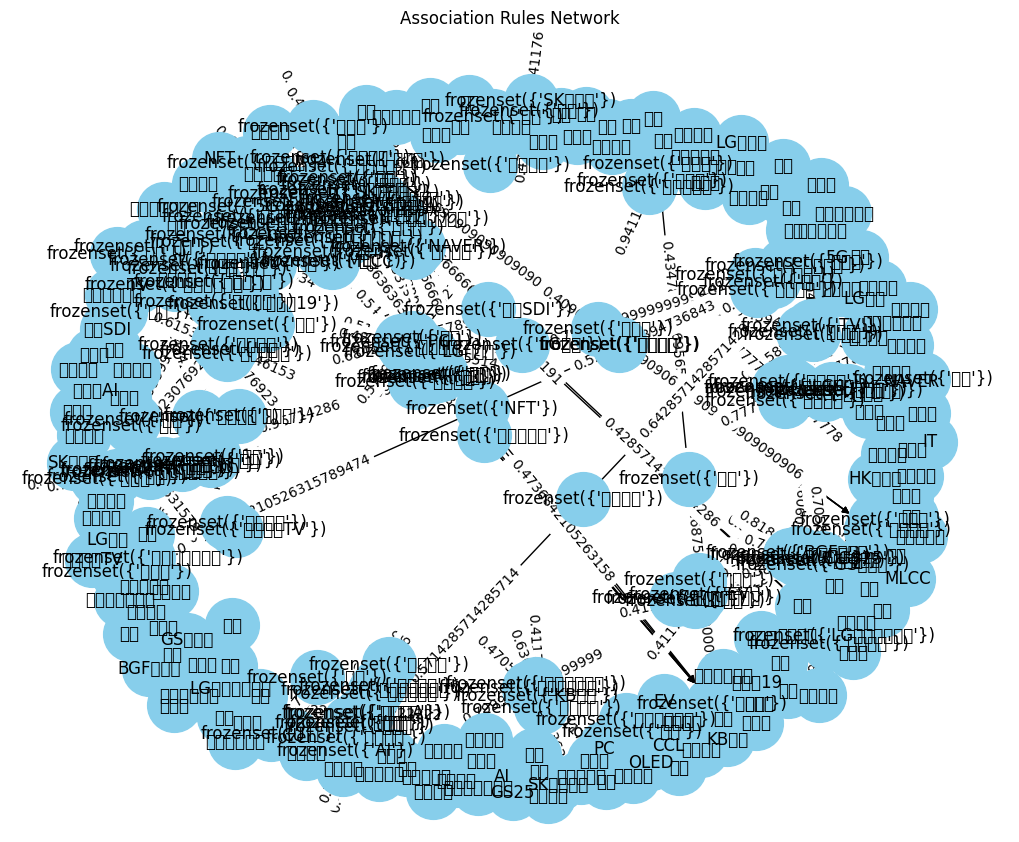

In [43]:
plt.figure(figsize=(10, 8))
nx.draw(
    direction_graph, pos, with_labels=True, labels=labels, node_size=1500, node_color='skyblue', font_size=12)
nx.draw_networkx_edge_labels(
    direction_graph, pos, edge_labels=weights, font_size=10)
plt.title("Association Rules Network")
plt.show()

노드(점) 생성

엣지(선) 생성

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 뉴스 데이터와 종목 데이터를 로드한다고 가정
news_data = pd.read_csv('news_data.csv')  # 뉴스 데이터가 담긴 CSV 파일
stock_data = pd.read_csv('stock_data.csv')  # 종목 데이터가 담긴 CSV 파일

# 유향그래프 생성
G = nx.DiGraph()

# 뉴스 데이터와 종목 데이터를 바탕으로 유향그래프를 생성한다고 가정
# 이때, 각 노드에는 종목 정보 또는 뉴스 정보를 할당합니다.
# 간선에는 confidence 값을 할당하여 장바구니 분석 결과와 연결합니다.

# 뉴스 데이터를 노드로 추가
for idx, news_row in news_data.iterrows():
    G.add_node(f"News_{idx}", data=news_row, type='News')

# 종목 데이터를 노드로 추가
for idx, stock_row in stock_data.iterrows():
    G.add_node(f"Stock_{idx}", data=stock_row, type='Stock')

# 장바구니 분석결과를 바탕으로 유향그래프에 간선 추가
# 여기서는 임의로 confidence 값 지정하겠습니다.
for idx, news_row in news_data.iterrows():
    for idx, stock_row in stock_data.iterrows():
        confidence = 0.8  # 임의로 설정한 confidence 값
        G.add_edge(f"News_{idx}", f"Stock_{idx}", confidence=confidence)

# 강한 연결 요소 탐지
strongly_connected_components = list(nx.strongly_connected_components(G))

# 강한 연결 요소별로 소비자 매수매도 종목 개수 확인
for idx, component in enumerate(strongly_connected_components):
    consumer_stocks = sum(1 for node in component if G.nodes[node]['type'] == 'Stock')
    print(f"강한 연결 요소 {idx + 1} 내의 소비자 매수매도 종목 개수: {consumer_stocks}")

# 그래프 시각화 (노드에 색깔 추가)
node_colors = []
for node in G.nodes():
    if G.nodes[node]['type'] == 'News':
        node_colors.append('red')
    else:
        node_colors.append('blue')

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos, node_size=300, node_color=node_colors, font_size=10, font_weight='bold', arrowsize=5, arrowstyle='fancy')
plt.show()


소비자 매도매수 종목에서 장바구니 분석결과에 대응하는 종목방향으로 장바구니 분석결과에서 장바구니 분석결과에 대응하는 종목 방향으로 장바구니 분석 결과를 confidence값의 크기에 따라서 더 큰값에서 작은값으로 가는 방법으로 유향그래프를 그리고 카잔 알고리즘을 사용하고 싶은데 거기에 소비자 매도매수 종목은 색깔같은특징을 부여해서 강한 연결 안에 몇 개나 들어가 있는지 알게 하는거

ChatGPT

소비자 매도매수 종목과 장바구니 분석결과를 바탕으로 유향그래프를 그리고 강한 연결 요소를 탐지하는 방법을 설명드리겠습니다. 이때 소비자 매도매수 종목에 색깔 같은 특징을 부여하여 강한 연결 내에서 소비자 매수매도 종목이 얼마나 포함되어 있는지를 파악할 수 있습니다.

• 데이터 전처리: 소비자 매도매수 종목과 장바구니 분석결과를 바탕으로 유향그래프를 생성하기 위해 필요한 데이터를 전처리합니다. 소비자 매도매수 종목과 장바구니 분석결과를 정리하고, confidence 값을 크기에 따라 정렬하여 장바구니 분석결과와 종목들 사이의 간선을 생성합니다.

• 유향그래프 생성: 전처리한 데이터를 바탕으로 유향그래프를 생성합니다. 소비자 매도매수 종목과 장바구니 분석결과를 노드로, confidence 값을 가중치로 하는 간선을 이용하여 그래프를 생성합니다.

• 강한 연결 요소 탐지: 생성된 유향그래프에서 카잔 알고리즘 등을 사용하여 강한 연결 요소를 탐지합니다.

• 색깔 특징 부여: 강한 연결 요소를 탐지한 후, 해당 요소 내의 노드들 중 소비자 매도매수 종목들에 색깔을 부여합니다. 예를 들어, 강한 연결 요소 내의 노드들은 같은 색으로 표시하고, 소비자 매수매도 종목들은 다른 색으로 표시합니다.

• 그래프 시각화: 최종적으로 생성된 유향그래프를 시각화하여 분석 결과를 확인합니다. 이때, 색깔 특징을 부여한 노드들이 어떻게 연결되어 있는지를 살펴봄으로써 소비자 매수매도 종목과 장바구니 분석결과 간의 강한 연결성과 중요성을 시각적으로 확인할 수 있습니다.

위와 같은 방법을 사용하여 소비자 매수매도 종목과 장바구니 분석결과를 연결하는 유향그래프를 생성하고, 강한 연결 요소를 찾아내며, 소비자 매수매도 종목에 색깔 특징을 부여하여 시각화함으로써 소비자의 투자에 대한 정보를 더욱 상세하게 분석할 수 있습니다. 이를 통해 소비자의 투자지식에 따른 포트폴리오 모델링과 투자심리지수 분석에 도움을 줄 수 있습니다.

카잔 알고리즘

• 그래프의 각 노드를 방문하지 않은 상태로 표시합니다.

• 각 노드에 대해 깊이 우선 탐색(DFS)을 수행합니다. 이 때, DFS를 수행하면서 방문한 노드들을 스택에 추가합니다.

• DFS를 모든 노드에 대해 수행하면서 스택에 추가된 노드들을 역순으로 꺼내면서 역방향 그래프(각 간선의 방향을 반대로 한 그래프)를 생성합니다.

• 역방향 그래프에 대해 다시 한 번 DFS를 수행하면서 강한 연결 요소를 찾아냅니다.